# diabetes dataset

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval.random import RandomEvaluator
from opendataval.dataval.margcontrib import LeaveOneOut, DataShapley, BetaShapley
from opendataval.dataval.influence import InfluenceFunctionEval
from opendataval.dataval.dvrl import DVRL
from opendataval.dataval.knnshap import KNNShapley
from opendataval.dataval.margcontrib.banzhaf import DataBanzhaf
from opendataval.dataval.ame import AME
from opendataval.dataval.oob import DataOob

from opendataval.experiment import ExperimentMediator

## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: diabetes
- Model: sklearn's linear regression model
- Metric: negative mean squred error

In [2]:
dataset_name = "diabetes"
train_count, valid_count, test_count = 100, 50, 50
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
model_name = "sklinreg"
metric_name = "neg_mse"

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=add_gauss_noise,
    noise_kwargs=noise_kwargs,
    train_kwargs={},
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='neg_mse': perf=-3201.8740234375


A full list of registered datasets can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/dataloader/fetcher.py#L121). A list of available  prediction models can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/model/__init__.py#L111).

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
    BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000) # Data-OOB
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000633


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 428.14it/s]


Elapsed time LeaveOneOut(): 0:00:00.241509


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 442.45it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:02.267087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 263.35it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:07.617893


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 11482.98it/s]

Elapsed time KNNShapley(k_neighbors=50): 0:00:00.020503
Start: marginal contribution computation



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.62it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.52it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.74it/s]

gr_stat=1.0291322568858143
Done: marginal contribution computation


Elapsed time DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:10.508221
Elapsed time BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:00.000499


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 514.06it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:01.954756


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 465.51it/s]


Elapsed time AME(num_models=1000): 0:00:07.468929


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.41it/s]

Elapsed time DataOob(num_models=1000): 0:00:02.729866
CPU times: user 31.9 s, sys: 98.9 ms, total: 32 s
Wall time: 32.8 s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/diabetes_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: perturbed features with additive Gaussian noise

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.000000
"BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.183486
DVRL(rl_epochs=2000),0.185185
DataBanzhaf(num_models=1000),0.077670
DataOob(num_models=1000),0.666667
"DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.183486
InfluenceFunctionEval(num_models=1000),0.148148
KNNShapley(k_neighbors=50),0.206897
LeaveOneOut(),0.130841
RandomEvaluator(),0.218182


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

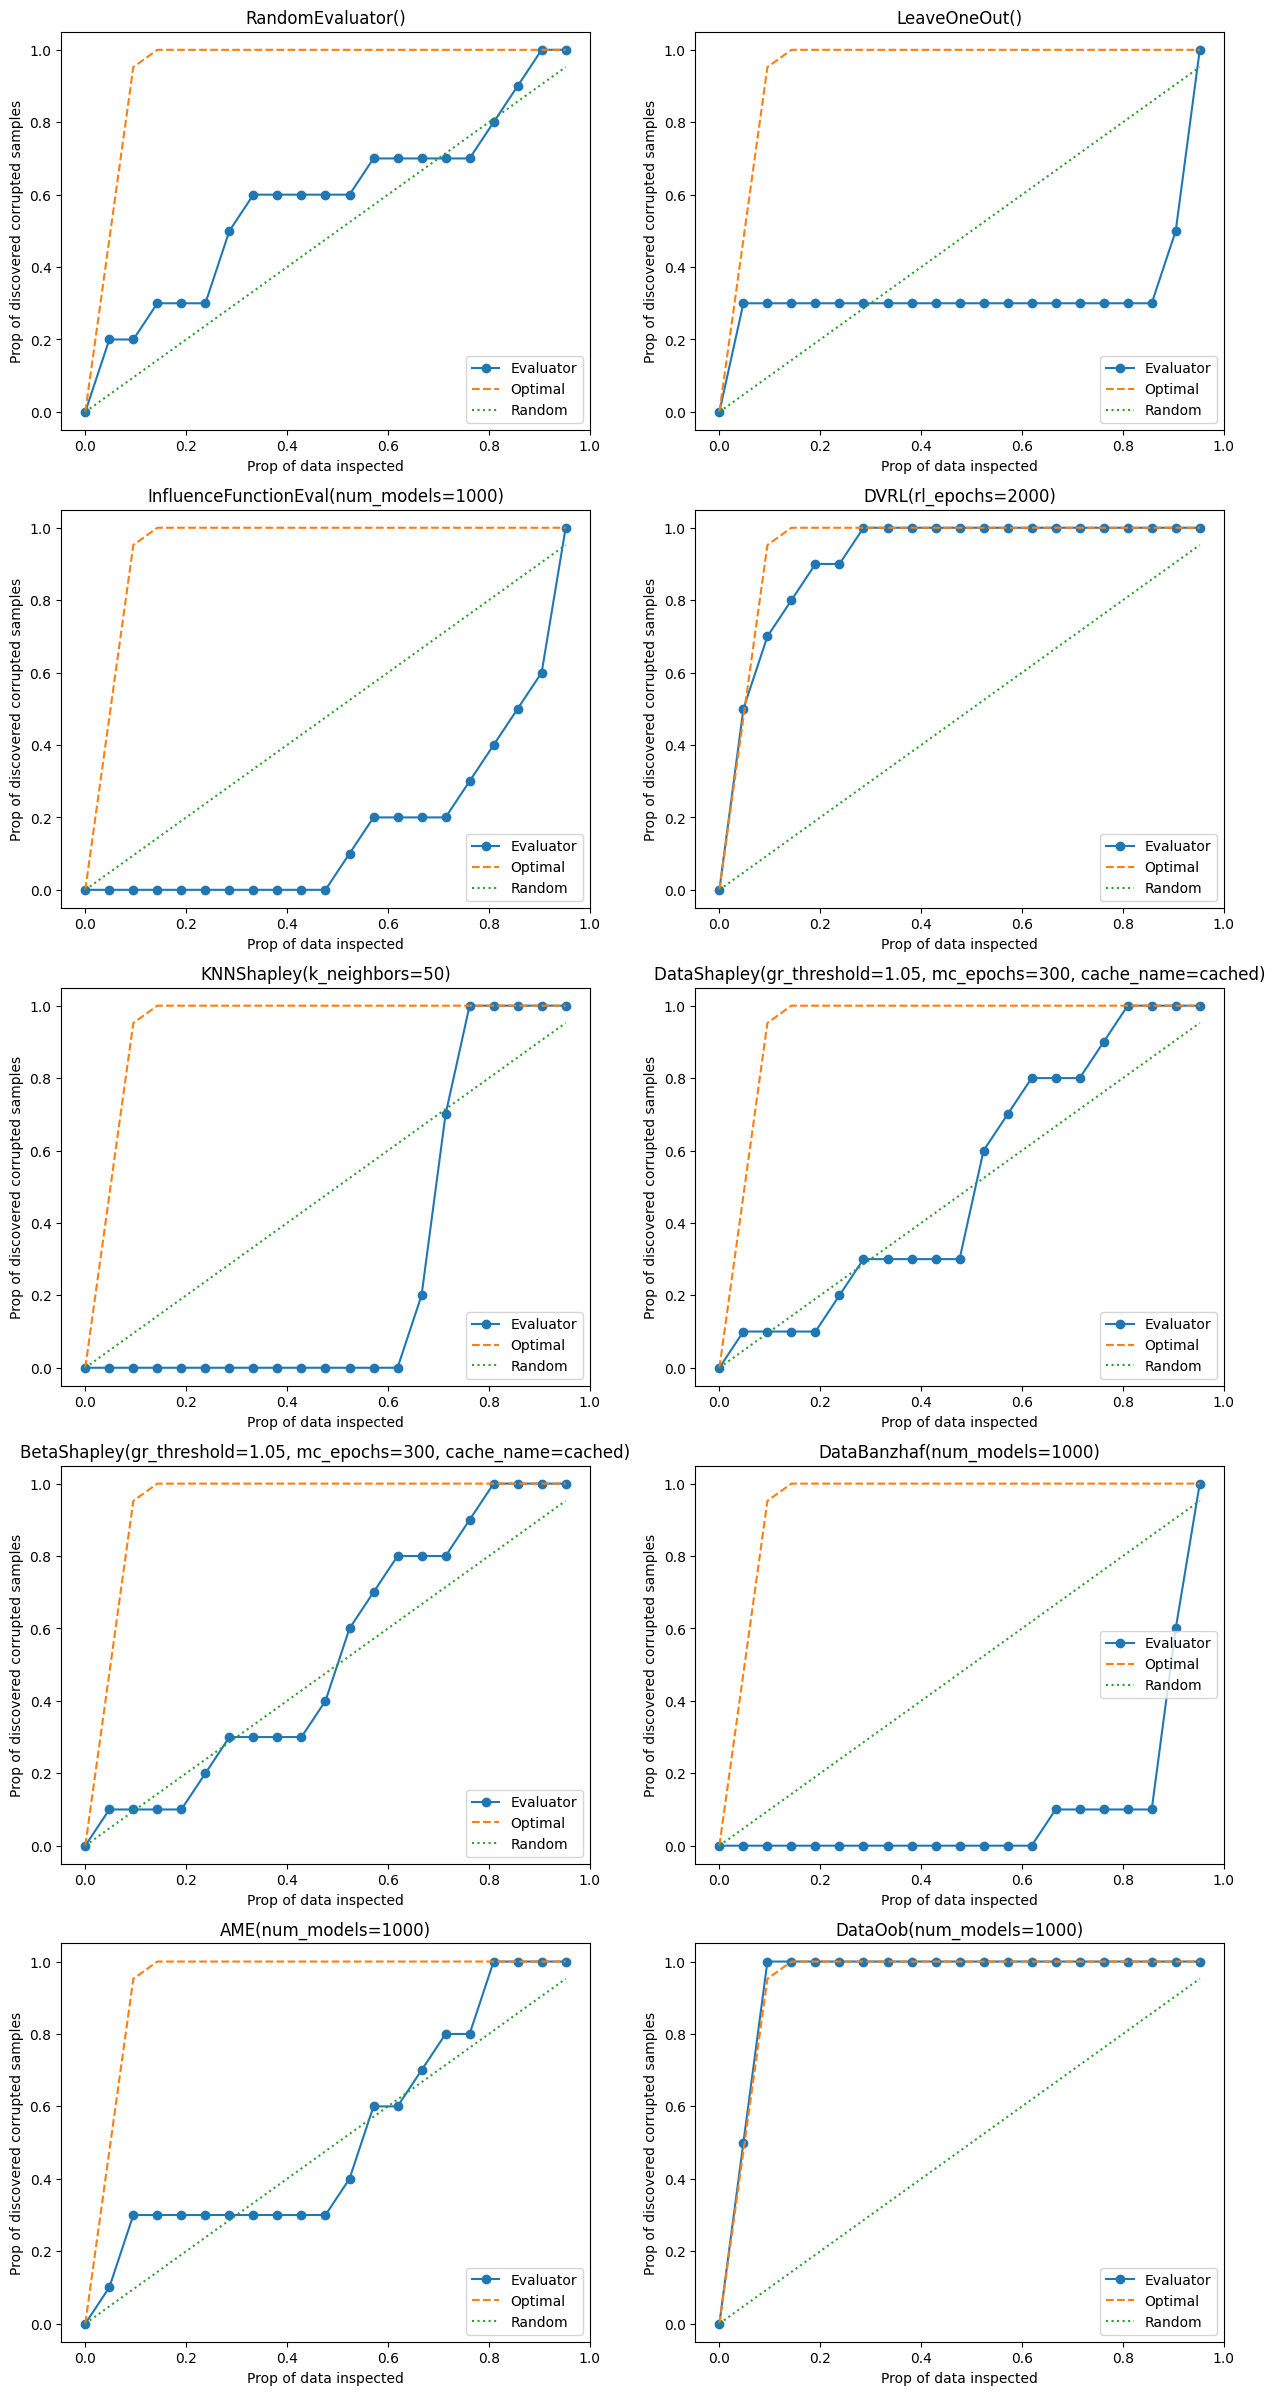

In [7]:
fig = plt.figure(figsize=(15, 30))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

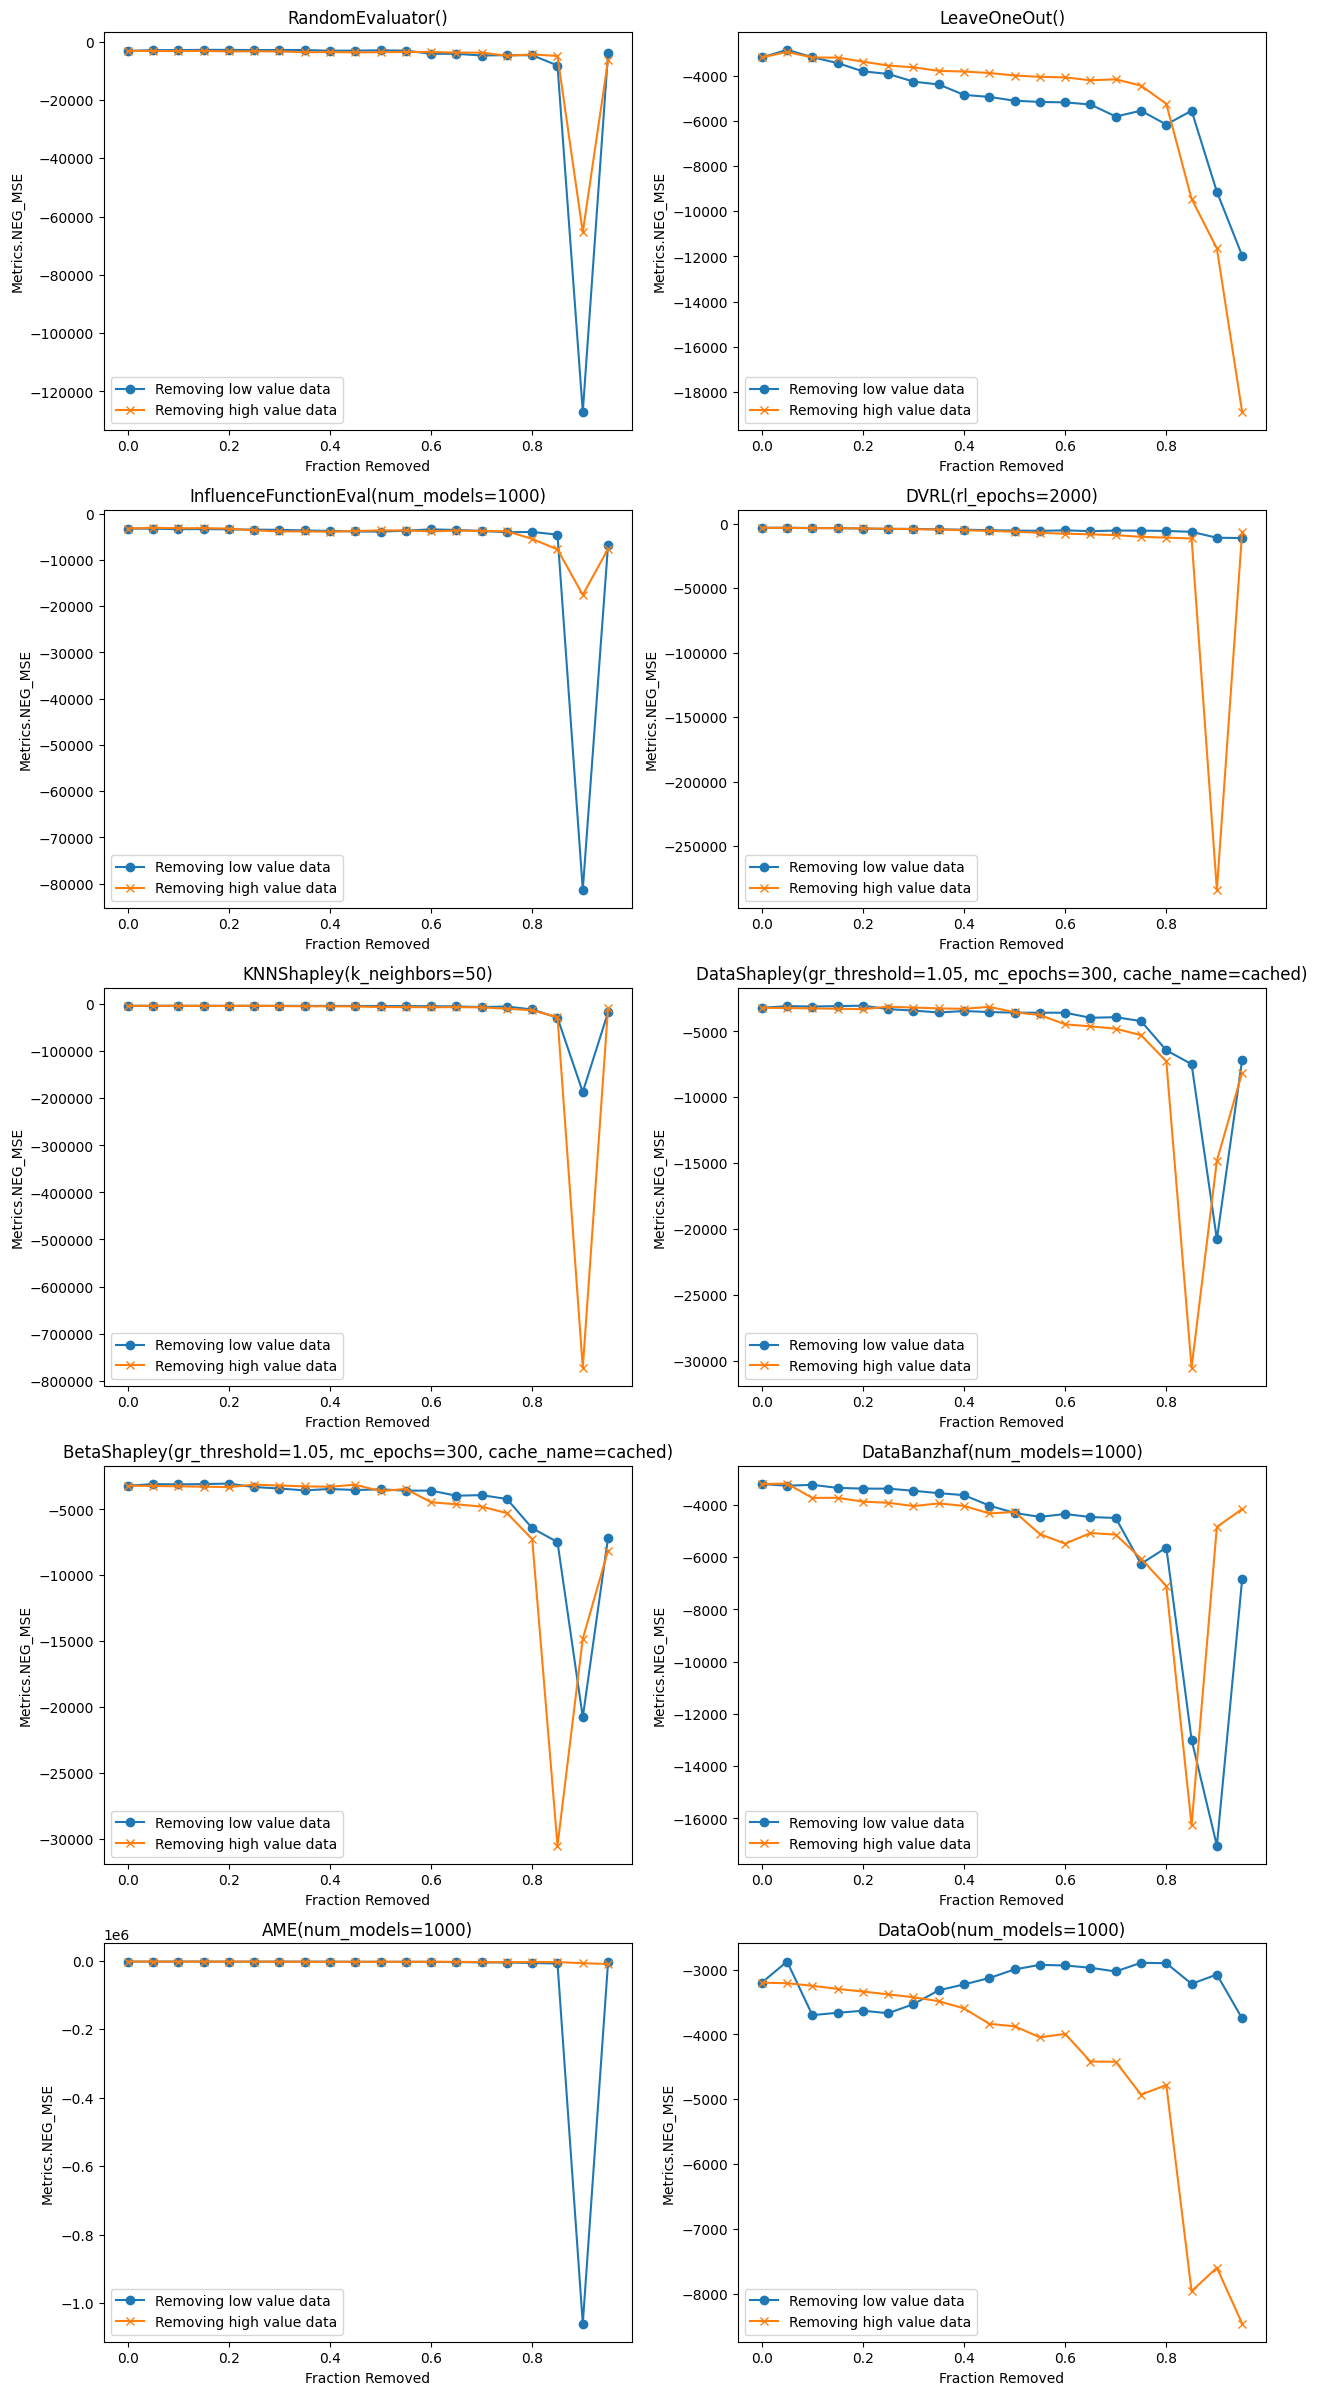

In [8]:
fig = plt.figure(figsize=(15, 30))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-3201.874023,-3201.874023,0.0
RandomEvaluator(),-2940.821777,-3234.67334,0.05
RandomEvaluator(),-2936.113037,-3288.687256,0.1
RandomEvaluator(),-2831.952148,-3188.95166,0.15
RandomEvaluator(),-2852.94873,-3391.745605,0.2
...,...,...,...
DataOob(num_models=1000),-2895.631348,-4929.250488,0.75
DataOob(num_models=1000),-2902.589355,-4779.681641,0.8
DataOob(num_models=1000),-3220.834473,-7959.816895,0.85
DataOob(num_models=1000),-3076.671631,-7596.439941,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),50,0.618573
RandomEvaluator(),399,0.52308
RandomEvaluator(),420,0.649896
RandomEvaluator(),234,0.152647
RandomEvaluator(),334,0.99269
...,...,...
DataOob(num_models=1000),176,-6852.879883
DataOob(num_models=1000),262,-7895.987793
DataOob(num_models=1000),317,-266.221954
DataOob(num_models=1000),132,-533.902893
